In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from pathlib import Path
from sklearn.model_selection import train_test_split
import gzip

In [6]:
data_path = Path("../data/hand-writing/")
train_path = data_path / "train-images-idx3-ubyte.gz"
train_labels_path = data_path / "train-labels-idx1-ubyte.gz"

In [8]:
def read_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True,image_size=28, n_components=None):
    f_images = gzip.open(images_path, 'r')
    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)
    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)
    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)
    # Read labels
    f_labels = gzip.open(labels_path, 'r')
    f_labels.read(8)
    labels = np.zeros((real_num)).astype(np.int64)

    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)

    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        images = images[rand_id, :]
        labels = labels[rand_id,]

    images = images.reshape(num_images, image_size * image_size)
    return images, labels


In [12]:
images0, labels0 = read_mnist_data(train_path, train_labels_path, 5000, shuffle=True)
train_images0, test_images0, train_labels0, test_labels0 = train_test_split(images0, labels0, test_size=0.3, random_state=192)
# test_images0, test_labels0 = read_mnist_data(test_path, test_labels_path, 10000, _is=False, shuffle=True)

print(train_images0.shape)
print(test_labels0.shape)

(3500, 784)
(1500,)


In [13]:
def display_network(A, m = -1, n = -1):
    opt_normalize = True
    opt_graycolor = True
    # Rescale
    A = A - np.average(A)
    # Compute rows & cols
    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1

    if m < 0 or n < 0:
        n = np.ceil(np.sqrt(col))
        m = np.ceil(col / n)

    image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))

    if not opt_graycolor:
        image *= 0.1
    k = 0

    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue
            clim = np.max(np.abs(A[:, k]))

            if opt_normalize:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = A[:, k].reshape(sz, sz) / clim
            else:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = A[:, k].reshape(sz, sz) / np.max(np.abs(A))


    return image



In [20]:
K = 10
kmeans = KMeans(n_clusters=K).fit(train_images0)

pred_label = kmeans.predict(train_images0)
pred_label



c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([7, 0, 2, ..., 3, 5, 0])

<class 'numpy.ndarray'>
(784, 10)


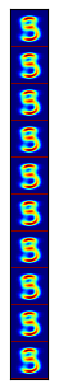

In [26]:
print(type(kmeans.cluster_centers_.T))
print(kmeans.cluster_centers_.T.shape)
A = display_network(kmeans.cluster_centers_.T, K, 1)

f1 = plt.imshow(A, interpolation='nearest', cmap = "jet")
f1.axes.get_xaxis().set_visible(False)
f1.axes.get_yaxis().set_visible(False)
plt.show()

cmap = plt.cm.jet
norm = plt.Normalize(vmin=A.min(), vmax=A.max())

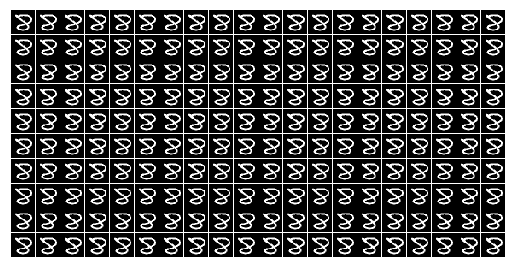

In [34]:
N0 = 20
X1 = np.zeros((N0*K, 784))
X2 = np.zeros((N0*K, 784))
for k in range(K):
    Xk = train_images0[pred_label == k, :]
    center_k = [kmeans.cluster_centers_[k]]
    neigh = NearestNeighbors(n_neighbors=N0)
    neigh.fit(Xk)
    dist, nearest_id = neigh.kneighbors(center_k, N0)
    X1[N0*k: N0*k + N0,:] = Xk[nearest_id, :]
    X2[N0*k: N0*k + N0,:] = Xk[:N0, :]


plt.axis('off')
A = display_network(X2.T, K, N0)
f2 = plt.imshow(A, interpolation='nearest' )
plt.gray()
plt.show()